In [1]:
import os
import numpy as np
import rasterio
from rasterio.plot import show
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, RandomSampler
import matplotlib.pyplot as plt

In [2]:
# Define paths to local .tif files
image_path = "C:/Users/Chris/Documents/BCMCA/bcmca_small_true.tif"
mask_path = "C:/Users/Chris/Documents/BCMCA/bcmca_mask.tif"

In [3]:
class CustomGeoDataset(Dataset):
    def __init__(self, image_path, mask_path, patch_size=256):
        self.image_path = image_path
        self.mask_path = mask_path
        self.patch_size = patch_size

        # Open the images
        self.image_src = rasterio.open(self.image_path)
        self.mask_src = rasterio.open(self.mask_path)
        self.height, self.width = self.image_src.height, self.image_src.width

    def __len__(self):
        # We will define an arbitrary number of samples
        return 1000  # Modify as per your requirement

    def __getitem__(self, idx):
        x = np.random.randint(0, self.width - self.patch_size)
        y = np.random.randint(0, self.height - self.patch_size)

        image = self.image_src.read(window=rasterio.windows.Window(x, y, self.patch_size, self.patch_size))
        mask = self.mask_src.read(1, window=rasterio.windows.Window(x, y, self.patch_size, self.patch_size))

        # Convert to torch tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()

        # Normalize the image to range [0, 1] if necessary
        image = image / 255.0

        sample = {"image": image, "mask": mask}
        return sample

In [4]:
# Create dataset instances
train_dataset = CustomGeoDataset(image_path, mask_path)
val_dataset = CustomGeoDataset(image_path, mask_path)  # Use the same for validation for now

In [5]:
# Set the ratio for splitting into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
total_samples = 100  # Samples number after augmentation
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size

# Use RandomSampler to sample regions from the dataset
train_sampler = RandomSampler(train_dataset, num_samples=train_size, replacement=True)
val_sampler = RandomSampler(val_dataset, num_samples=val_size, replacement=True)

train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=16)
val_loader = DataLoader(val_dataset, sampler=val_sampler, batch_size=16)

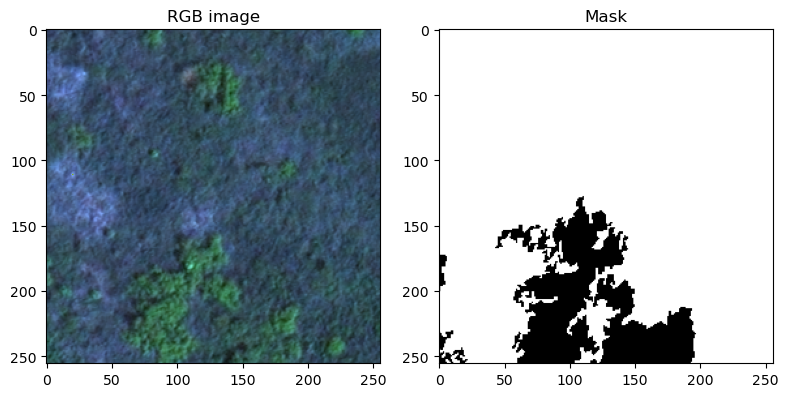

In [6]:
# Let's print a random element of the training dataset
random_element = np.random.randint(0, len(train_loader))
for idx, sample in enumerate(train_loader):
    if idx != random_element:
        continue

    # Let's select the first sample from the batch
    image = sample["image"][0]
    target = sample["mask"][0]

    # Ensure the image has 3 bands (RGB)
    if image.shape[0] == 3:
        # Create a figure and a 1x2 grid of axes
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # Plot the first image in the left axis
        # Select only first 3 bands and cast to uint8
        rgb_image = np.transpose(image.numpy().squeeze(), (1, 2, 0))
        axes[0].imshow((rgb_image * 255).astype('uint8'))
        axes[0].set_title('RGB image')

        # Plot the labels image in the right axis
        target_image = target.numpy().squeeze()
        axes[1].imshow(target_image, cmap='gray')
        axes[1].set_title('Mask')

        # Adjust layout to prevent clipping of titles
        plt.tight_layout()

        # Show the plots
        plt.show()
    else:
        print("Image does not have 3 bands.")

In [7]:
print(f"RGB Image min: {rgb_image.min()}, max: {rgb_image.max()}")

RGB Image min: 0.0470588244497776, max: 1.003921627998352


In [8]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
from tqdm import tqdm

# Define necessary variables
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nb_channels = 3  # Number of input channels (RGB)
nb_classes = 1  # Number of output classes (binary mask)

# Initialize model, loss function, and optimizer
model = UNet(n_channels=nb_channels, n_classes=nb_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
log_dict = {'loss_per_batch': [], 'loss_per_epoch': []}
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        inputs = batch["image"][:, 0:3, :, :] / 255.0  # Normalize inputs to [0, 1]
        targets = batch["mask"].unsqueeze(1)  # Add a channel dimension

        # Move data to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())  # BCEWithLogitsLoss does not require sigmoid

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        log_dict['loss_per_batch'].append(loss.item())

    # Evaluation phase
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch["image"][:, 0:3, :, :] / 255.0  # Normalize inputs to [0, 1]
            val_targets = val_batch["mask"].unsqueeze(1)  # Add a channel dimension

            # Move data to device
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)

            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets.float())
            total_val_loss += val_loss.item()

    # Calculate the average loss
    average_val_loss = total_val_loss / len(val_loader)
    log_dict['loss_per_epoch'].append(average_val_loss)

    # Check if current performance is better than the best so far
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pt')

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader.dataset)}, Validation Loss: {average_val_loss}")


100%|██████████| 5/5 [00:31<00:00,  6.29s/it]


Epoch 1/10, Training Loss: 0.04297758960723877, Validation Loss: -4.582326769828796


100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


Epoch 2/10, Training Loss: -0.05727457904815674, Validation Loss: 1.214709997177124


100%|██████████| 5/5 [00:24<00:00,  4.83s/it]


Epoch 3/10, Training Loss: -0.021384445786476136, Validation Loss: 1.2059199810028076


100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


Epoch 4/10, Training Loss: -0.08165890979766846, Validation Loss: 0.8475048243999481


100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


Epoch 5/10, Training Loss: -0.06997087025642396, Validation Loss: 0.8395829796791077


100%|██████████| 5/5 [00:25<00:00,  5.07s/it]


Epoch 6/10, Training Loss: -0.11317436075210571, Validation Loss: 0.5319498181343079


100%|██████████| 5/5 [00:22<00:00,  4.58s/it]


Epoch 7/10, Training Loss: -0.16350106048583984, Validation Loss: 1.2164263129234314


100%|██████████| 5/5 [00:23<00:00,  4.73s/it]


Epoch 8/10, Training Loss: -0.17356944465637206, Validation Loss: 0.8884328603744507


  0%|          | 0/5 [00:00<?, ?it/s]

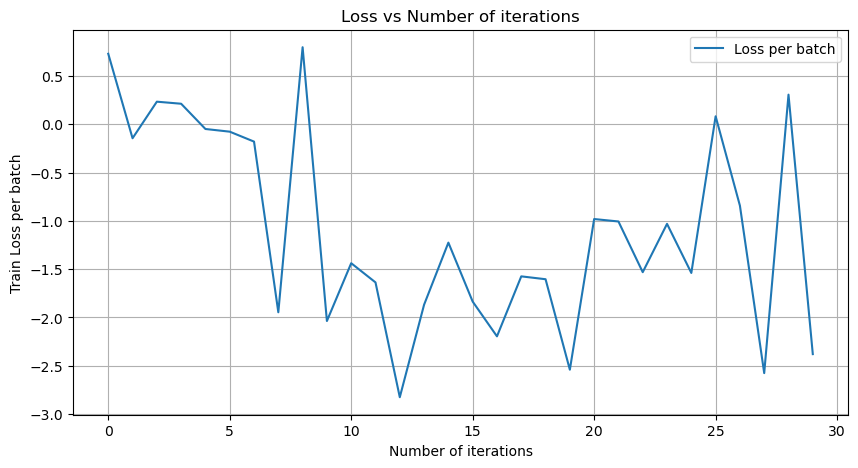

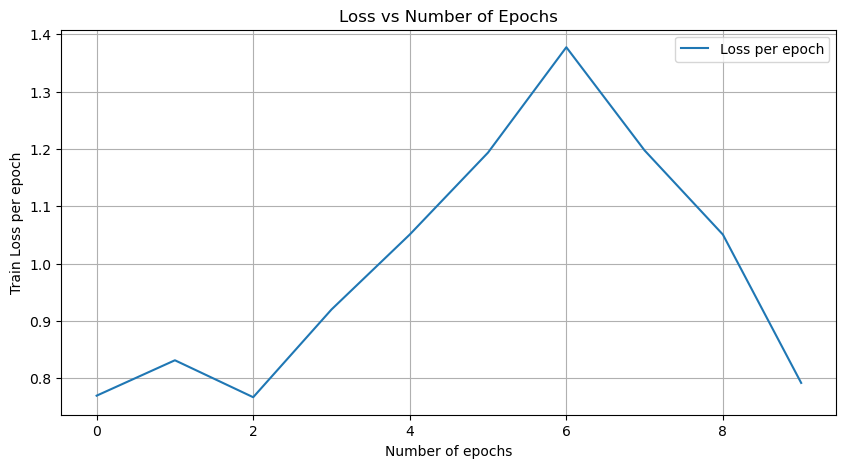

In [10]:
# Load the trained model
model = UNet(n_channels=nb_channels, n_classes=nb_classes).to(device)
state_dict = torch.load('best_model.pt', map_location=device)
model.load_state_dict(state_dict)

# Visualization of training loss per batch
plt.figure(figsize=(10, 5))
plt.plot(log_dict['loss_per_batch'], label='Loss per batch')
plt.xlabel("Number of iterations")
plt.ylabel("Train Loss per batch")
plt.title("Loss vs Number of iterations")
plt.grid()
plt.legend()
plt.show()

# Visualization of training loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(log_dict['loss_per_epoch'], label='Loss per epoch')
plt.xlabel("Number of epochs")
plt.ylabel("Train Loss per epoch")
plt.title("Loss vs Number of Epochs")
plt.grid()
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss on current batch: 0.9552876353263855


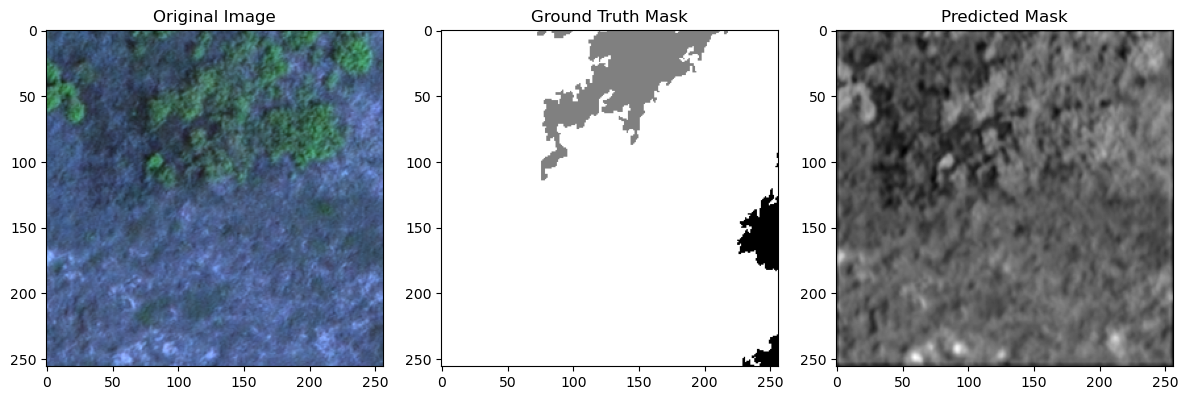

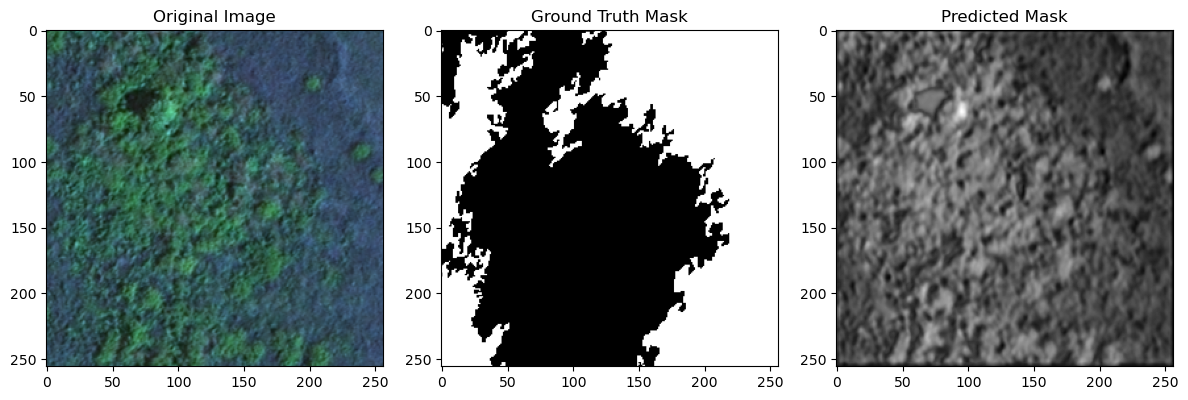

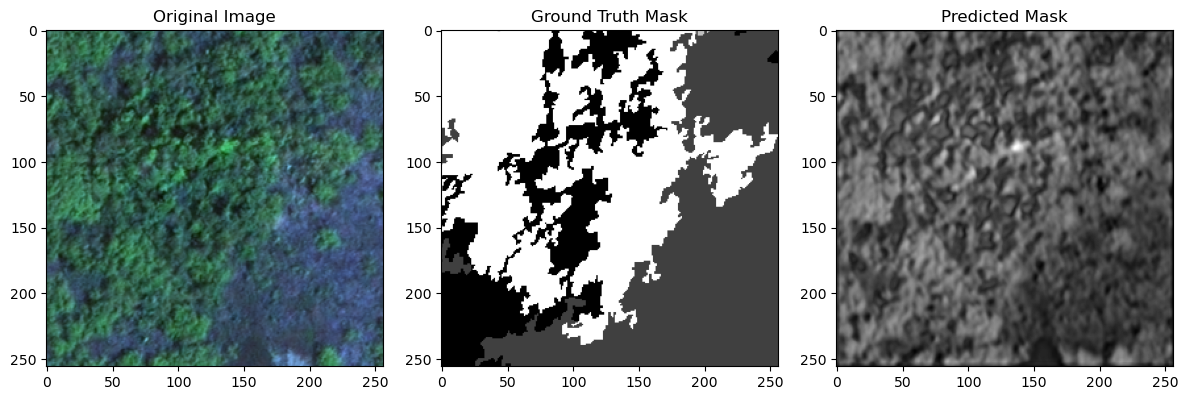

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


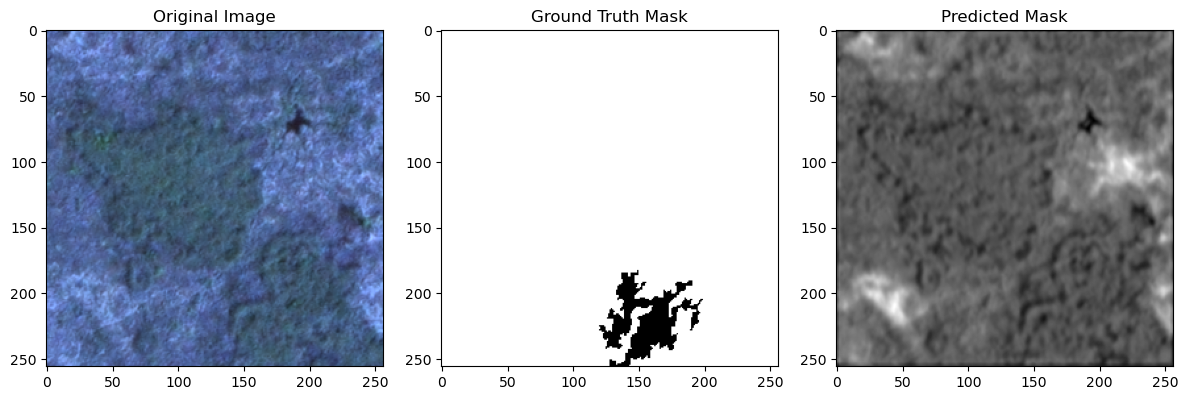

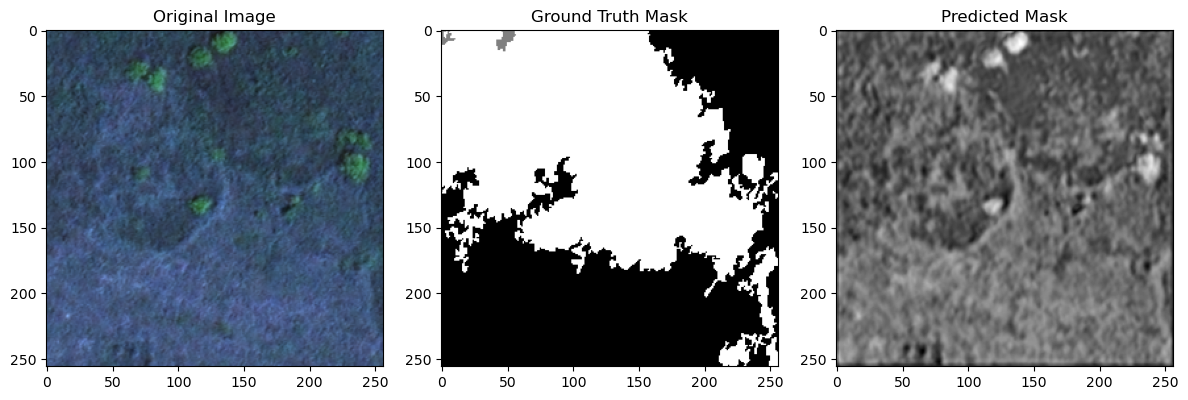

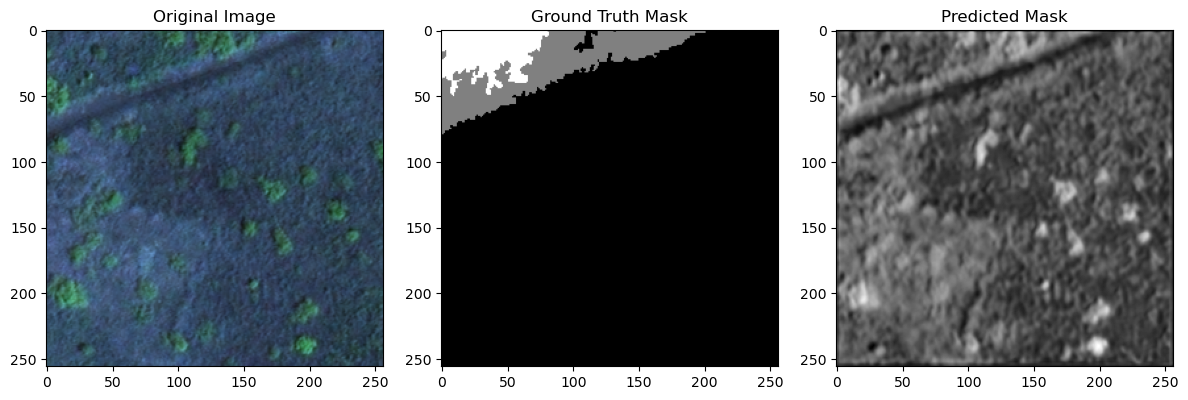

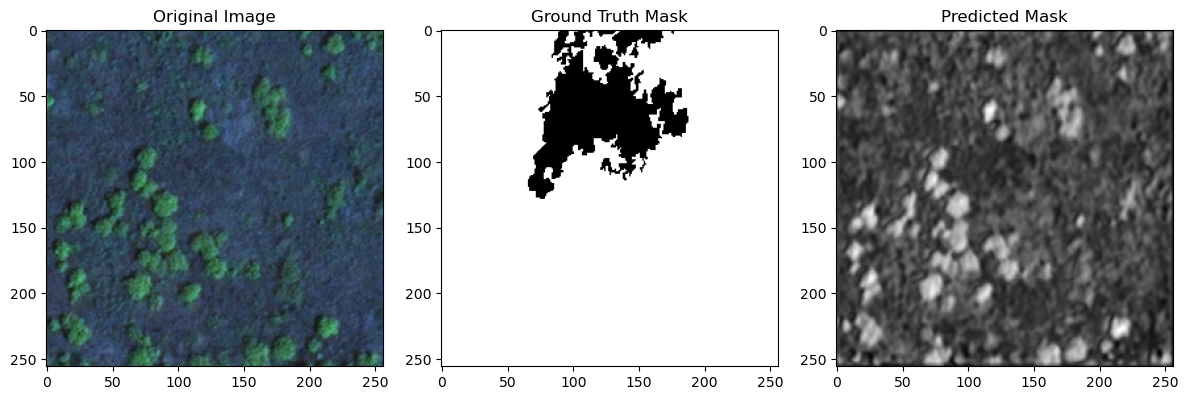

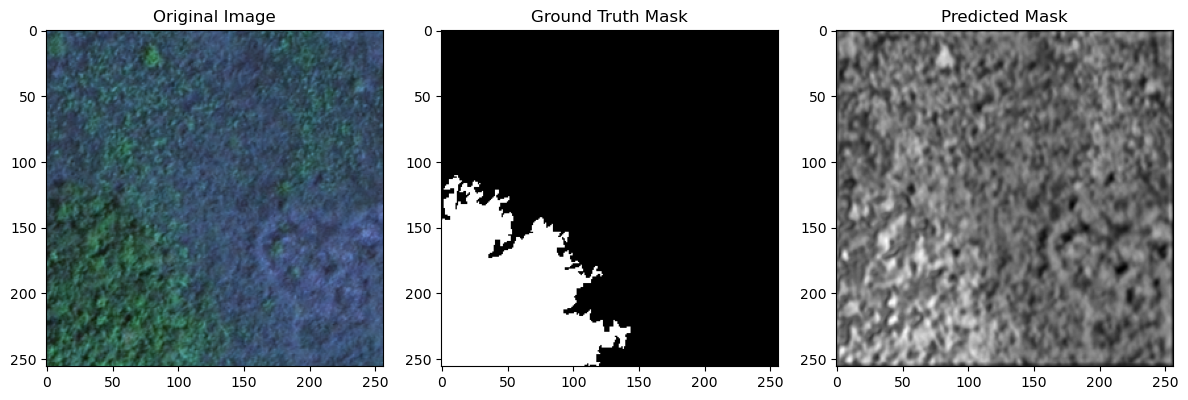

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


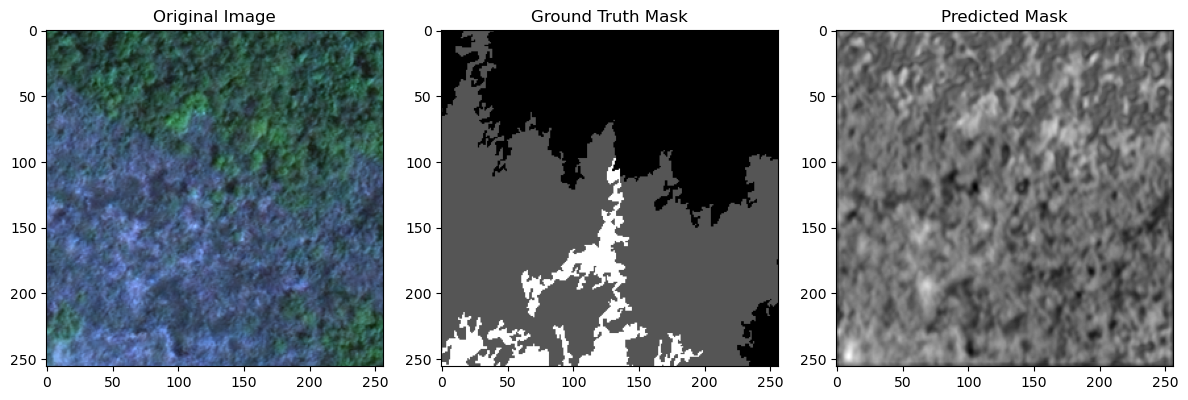

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


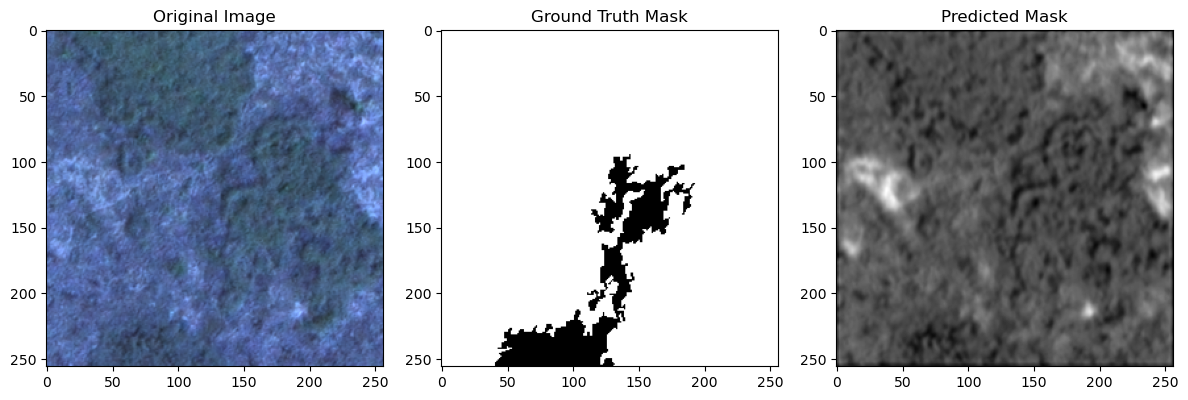

Average Loss on Validation Set: 0.9552876353263855


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store metrics for averaging later
all_losses = []

# Iterate over batches or samples in the validation loader
for batch in val_loader:
    # Extract batch of images and masks
    inputs = batch["image"][:, 0:3, :, :]  # Select only first 3 channels
    targets = batch["mask"]

    # Move data to device
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets.unsqueeze(1).float())

        # Convert logits to predicted class labels (assuming binary classification)
        predicted_masks = torch.sigmoid(outputs)

        # Convert tensors to numpy arrays for visualization and metrics
        image_np = inputs.cpu().squeeze().numpy()  # Remove batch dimension and move to CPU
        target_np = targets.cpu().squeeze().numpy()
        predicted_mask_np = predicted_masks.cpu().squeeze().numpy()

        # Calculate and store loss
        all_losses.append(loss.item())

        # Optionally, print or use the calculated metrics
        print("Loss on current batch:", loss.item())

        # Iterate over the batch to plot each image and its masks
        for idx in range(len(image_np)):
            # Create a figure and a 1x3 grid of axes
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            # Plot the original image
            axes[0].imshow(image_np[idx].transpose((1, 2, 0)))  # Transpose to (H, W, C) for plotting
            axes[0].set_title('Original Image')

            # Plot the ground truth mask (grayscale)
            axes[1].imshow(target_np[idx], cmap='gray')
            axes[1].set_title('Ground Truth Mask')

            # Plot the predicted mask (grayscale)
            axes[2].imshow(predicted_mask_np[idx], cmap='gray')
            axes[2].set_title('Predicted Mask')

            # Adjust layout to prevent clipping of titles
            plt.tight_layout()

            # Show the plots for the current image
            plt.show()

# Calculate average loss over all batches
average_loss = np.mean(all_losses)
print("Average Loss on Validation Set:", average_loss)

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define the Dice coefficient and Dice loss functions for multi-class segmentation
def dice_coefficient(pred, target, smooth=1.0):
    pred = torch.softmax(pred, dim=1)
    target_one_hot = nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.softmax(pred, dim=1)
    target_one_hot = nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice.mean()

# Set the model to evaluation mode
model.eval()

# Initialize lists to store metrics for averaging later
all_losses = []

# Define the criterion for cross-entropy loss
criterion_ce = nn.CrossEntropyLoss()

# Debugging: print input and target shapes and check label values
def debug_tensors(inputs, targets):
    print(f"Inputs shape: {inputs.shape}")
    print(f"Targets shape: {targets.shape}")
    unique_labels = torch.unique(targets)
    print(f"Unique labels in targets: {unique_labels}")

# Iterate over batches or samples in the validation loader
for batch in val_loader:
    # Extract batch of images and masks
    inputs = batch["image"][:, 0:3, :, :]  # Select only first 3 channels
    targets = batch["mask"]

    # Debugging: Check input and target shapes and values
    debug_tensors(inputs, targets)

    # Move data to device
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss_ce = criterion_ce(outputs, targets)
        loss_dice = dice_loss(outputs, targets)
        loss = loss_ce + loss_dice  # Combine CE and Dice loss

        # Convert logits to predicted class labels
        predicted_masks = torch.argmax(outputs, dim=1)

        # Convert tensors to numpy arrays for visualization and metrics
        image_np = inputs.cpu().squeeze().numpy()  # Remove batch dimension and move to CPU
        target_np = targets.cpu().squeeze().numpy()
        predicted_mask_np = predicted_masks.cpu().squeeze().numpy()

        # Calculate and store loss
        all_losses.append(loss.item())

        # Optionally, print or use the calculated metrics
        print("Loss on current batch:", loss.item())

        # Iterate over the batch to plot each image and its masks
        for idx in range(len(image_np)):
            # Create a figure and a 1x3 grid of axes
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            # Plot the original image
            axes[0].imshow(image_np[idx].transpose((1, 2, 0)))  # Transpose to (H, W, C) for plotting
            axes[0].set_title('Original Image')

            # Plot the ground truth mask (grayscale)
            axes[1].imshow(target_np[idx], cmap='gray')
            axes[1].set_title('Ground Truth Mask')

            # Plot the predicted mask without grayscale
            axes[2].imshow(predicted_mask_np[idx], vmin=0, vmax=np.max(predicted_mask_np[idx]))
            axes[2].set_title('Predicted Mask')

            # Adjust layout to prevent clipping of titles
            plt.tight_layout()

            # Show the plots for the current image
            plt.show()

# Calculate average loss over all batches
average_loss = np.mean(all_losses)
print("Average Loss on Validation Set:", average_loss)Inputs shape: torch.Size([4, 3, 256, 256])
Targets shape: torch.Size([4, 256, 256])
Unique labels in targets: tensor([0, 1, 2, 5])
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
Cell In[15], line 49
     46 debug_tensors(inputs, targets)
     48 # Move data to device
---> 49 inputs = inputs.to(device)
     50 targets = targets.to(device)
     52 with torch.no_grad():
     53     # Forward pass

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Inputs shape: torch.Size([4, 3, 256, 256])
Targets shape: torch.Size([4, 256, 256])
Unique labels in targets: tensor([0, 1, 2, 5])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
